In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

### 1. Метод главных компонент
##### Cингулярное матричные разложения

In [2]:
# Модифицированный метод Грама-Шмидта для QR-разложения
def modified_gs(matrix: np.array) -> (np.array, np.array):
    n = matrix.shape[1]
    q = np.array(matrix, dtype='float64')
    r = np.zeros((n, n))
    for i in range(n):
        a_i = q[:, i]
        r[i, i] = np.linalg.norm(a_i)
        a_i /= r[i, i]
        for j in range(i + 1, n):
            a_j = q[:, j]
            r[i, j] = a_i.T @ a_j
            a_j -= r[i, j] * a_i
    return q, r

# Функция для вычисления собственных значений и векторов методом QR-разложения
def eigen_qr(A: np.array, iterations=1) -> (np.array, np.array):
    Ak = np.copy(A)
    n = A.shape[0]
    QQ = np.eye(n)
    for k in range(iterations):
        Q, R = modified_gs(Ak)
        Ak = R @ Q
        QQ = QQ @ Q
    return Ak, QQ

In [3]:
# Загрузка данных и предобработка
transactions = pd.read_csv("../data_2/transactions.csv", index_col="customer_id")
gender = pd.read_csv("../data_2/gender.csv", index_col="customer_id")
tr_mcc_codes = pd.read_csv("../data_2/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("../data_2/tr_types.csv", sep=";", index_col="tr_type")


# Соединение таблиц и создание признаков
df = transactions.reset_index().merge(tr_mcc_codes, on='mcc_code', how='left')\
                                 .merge(tr_types, on='tr_type', how='left')\
                                 .merge(gender.reset_index(), on='customer_id', how='left')
df.set_index('customer_id', inplace=True)
df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
df['hour'] = df['tr_datetime'].str.extract(r'(\d+):\d+:\d+').astype(int)
df = df.drop(columns=['tr_datetime', 'term_id']).dropna(subset=['tr_description'])
df = pd.get_dummies(df, columns=['day', 'hour']).drop(columns=['mcc_code', 'tr_type', 'mcc_description', 'tr_description'])
df_mean = df.groupby(df.index).mean()
df_sum = df.groupby(df.index).sum()
df_sum['amount'] = df_mean['amount']
df_sum['gender'] = df_mean['gender']


# Убираем выбросы
df_sum = df_sum[(df_sum['amount'] >= -200000) & (df_sum['amount'] <= 200000)]
train_data = df_sum.dropna()
test_data = df_sum[df_sum['gender'].isnull()]
y_target = train_data['gender']
train_data.drop('gender', axis=1, inplace=True)
X = train_data.values

/var/folders/c_/t45fjn6j75357jk8wg1gpqsr0000gn/T/ipykernel_33522/1153381742.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop('gender', axis=1, inplace=True)


In [4]:
# Нормализация данных
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

# Найдем ковариационную матрицу
Z = np.cov(X_norm.T)

# Найдем собственные числа и векторы ковариационной матрицы нашей
# функцией, основанной на qr-разложении
eig_vals, eig_vecs = eigen_qr(Z, 1000)
eig_vals = eig_vals.diagonal()


# Отсортируем собственные значения по убыванию в связке с собственными векторами
eig_pairs = [
    (eig_val, eig_vec, x_i) for eig_val, eig_vec, x_i in zip(eig_vals, eig_vecs, X_norm.T)
]

eig_pairs.sort(key=lambda x: x[0], reverse=True)

eig_vals = np.array([pair[0] for pair in eig_pairs])
eig_vecs = np.array([pair[1] for pair in eig_pairs])

/var/folders/c_/t45fjn6j75357jk8wg1gpqsr0000gn/T/ipykernel_33522/412590667.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


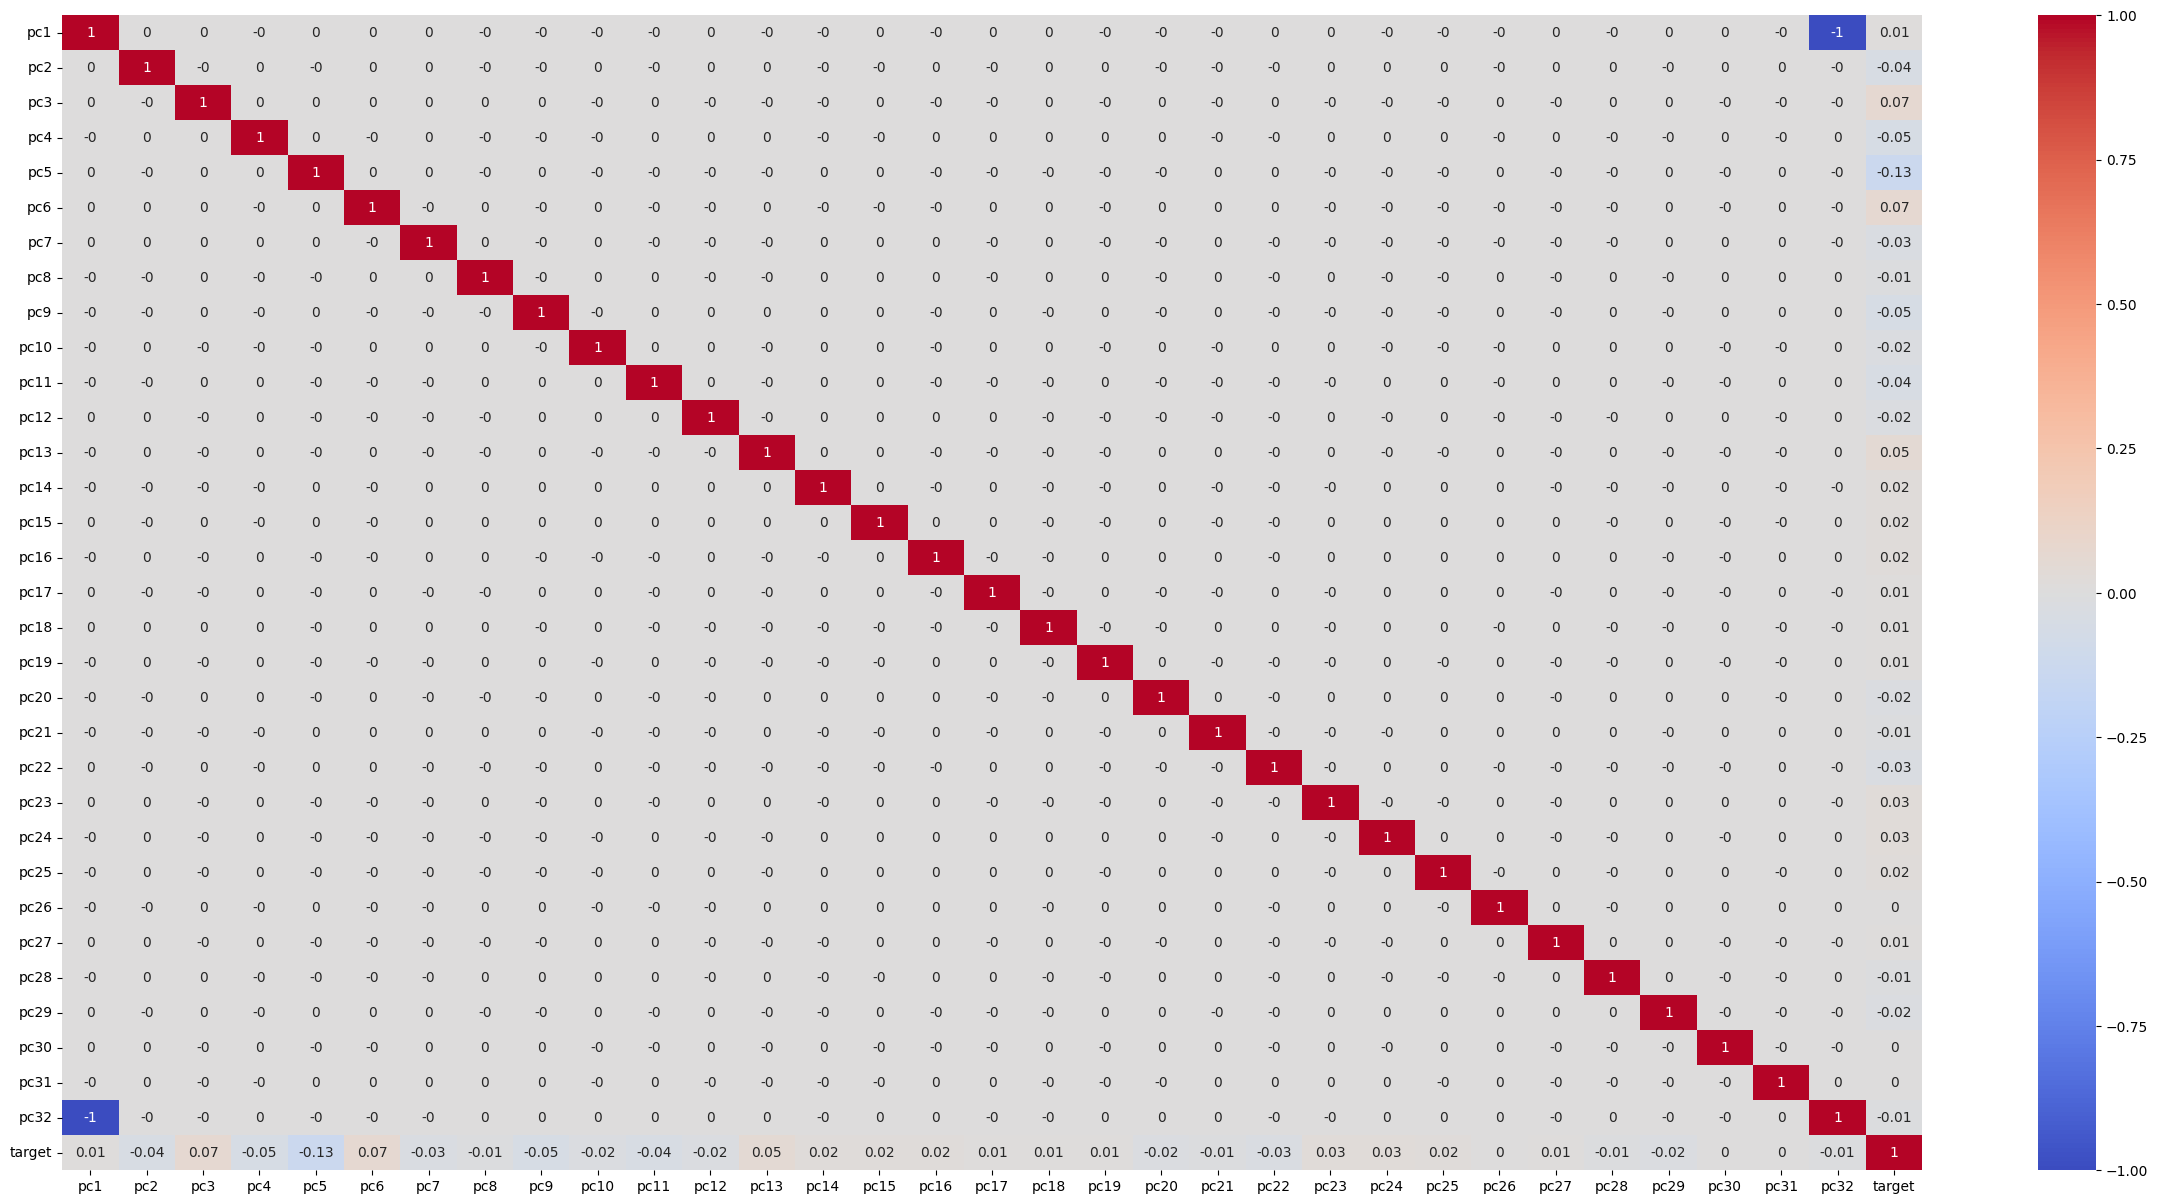

In [5]:
# Умножением нормированных данных и собственных векторов получим главные компоненты
# Главные компоненты мало коррелируют друг с другом, но коррелируют с таргетом
data_pca_full = X_norm@eig_vecs

df_pca_full = pd.DataFrame(data_pca_full, columns=['pc' + str(i) for i in range(1, X_norm.shape[1] + 1)])
df_pca_full['target'] = y_target.values

fig, ax = plt.subplots(figsize=(30, 15))

corr_pca = df_pca_full.corr()
sns.heatmap(
    corr_pca.round(2),
    cmap='coolwarm',
    center=0,
    annot=True
)

fig.show();

In [6]:
# посчитаем долю объясняемой компонентами дисперсии
explained_vars = [eig_val / eig_vals.sum() for eig_val in eig_vals]
explained_vars_cum = np.array(explained_vars).cumsum()
explained_vars_cum

array([0.64831539, 0.77727147, 0.82419663, 0.85869704, 0.88830001,
       0.91184212, 0.92958622, 0.93858213, 0.94560218, 0.9522617 ,
       0.95829248, 0.96288969, 0.9668847 , 0.97062999, 0.97413868,
       0.97697858, 0.97944946, 0.98159448, 0.98366899, 0.98561822,
       0.98751446, 0.98920253, 0.99085894, 0.99244289, 0.99394752,
       0.99535028, 0.99658908, 0.99775702, 0.99884512, 0.99959209,
       1.        , 1.        ])

/var/folders/c_/t45fjn6j75357jk8wg1gpqsr0000gn/T/ipykernel_33522/2327313719.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


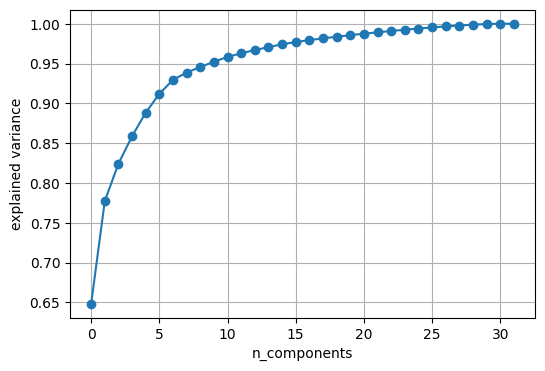

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(explained_vars_cum, marker='o');
ax.set_xlabel('n_components')
ax.set_ylabel('explained variance')
ax.grid()
fig.show()

In [8]:
# Чтобы сохранить 95% дисперсии необходимо взять первые 9 компонент
# сверим результат с реализацией из sklearn'а
# т.к. знаки могут чередоваться по-разному (при этом дисперсия будет той же)
# сравниваем по модулю

pc10_vecs = eig_vecs[:, :10]
pc10_data = X_norm@pc10_vecs

pca_house = PCA(.95)
principalComponents_house = pca_house.fit_transform(X_norm)

assert np.allclose(pca_house.explained_variance_ratio_, np.array(explained_vars[:10]))
assert np.allclose(np.abs(principalComponents_house), np.abs(pc10_data))

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt

X_train, X_val, y_train, y_val = train_test_split(train_data, y_target, test_size=0.2, random_state=42)

# Преобразование данных в формат PyTorch
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [12]:
# Определение модели нейросети
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Функция для обучения модели
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs=100):
    train_losses = []
    val_auc_scores = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Валидация
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val).squeeze()
            val_outputs_prob = val_outputs.numpy()
            val_auc = roc_auc_score(y_val, val_outputs_prob)
        
        train_losses.append(loss.item())
        val_auc_scores.append(val_auc)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val ROC-AUC: {val_auc:.4f}')

    return train_losses, val_auc_scores

In [13]:
# Определение гиперпараметров
input_dim = X_train_tensor.shape[1]  # число признаков в исходных данных
model1 = SimpleNN(input_dim)
criterion = nn.BCELoss()  # функция потерь
optimizer = optim.Adam(model1.parameters(), lr=0.001)  # оптимизатор

# Обучение и замер времени на исходных данных
print("Обучение на исходных данных...")
start_time = time.time()
train_losses1, val_accuracies1 = train_model(model1, X_train_tensor, y_train_tensor, 
                                             X_val_tensor, y_val_tensor, criterion, 
                                             optimizer, epochs=150)
end_time = time.time()
print("Время обучения на исходных данных:", end_time - start_time, "секунд")

Обучение на исходных данных...
Epoch [10/150], Loss: 0.6870, Val ROC-AUC: 0.5296
Epoch [20/150], Loss: 0.6851, Val ROC-AUC: 0.5630
Epoch [30/150], Loss: 0.6829, Val ROC-AUC: 0.5834
Epoch [40/150], Loss: 0.6805, Val ROC-AUC: 0.5973
Epoch [50/150], Loss: 0.6775, Val ROC-AUC: 0.6116
Epoch [60/150], Loss: 0.6739, Val ROC-AUC: 0.6233
Epoch [70/150], Loss: 0.6703, Val ROC-AUC: 0.6359
Epoch [80/150], Loss: 0.6664, Val ROC-AUC: 0.6442
Epoch [90/150], Loss: 0.6627, Val ROC-AUC: 0.6475
Epoch [100/150], Loss: 0.6592, Val ROC-AUC: 0.6501
Epoch [110/150], Loss: 0.6561, Val ROC-AUC: 0.6532
Epoch [120/150], Loss: 0.6533, Val ROC-AUC: 0.6566
Epoch [130/150], Loss: 0.6507, Val ROC-AUC: 0.6593
Epoch [140/150], Loss: 0.6483, Val ROC-AUC: 0.6611
Epoch [150/150], Loss: 0.6462, Val ROC-AUC: 0.6629
Время обучения на исходных данных: 0.47093892097473145 секунд


In [52]:
# Разделение и преобразование данных после PCA
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(pc10_data, y_target, test_size=0.2, random_state=42)
X_train_tensor_pca = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor_pca = torch.tensor(y_train_pca.values, dtype=torch.float32)
X_val_tensor_pca = torch.tensor(X_val_pca, dtype=torch.float32)
y_val_tensor_pca = torch.tensor(y_val_pca.values, dtype=torch.float32)

# Определение модели для данных после PCA
input_dim_pca = X_train_tensor_pca.shape[1]
model2 = SimpleNN(input_dim_pca)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Обучение и замер времени на данных после PCA
print("Обучение на данных после PCA...")
start_time_pca = time.time()
train_losses2, val_auc_scores2 = train_model(model2, X_train_tensor_pca, y_train_tensor_pca, X_val_tensor_pca, y_val_tensor_pca, criterion, optimizer2, epochs=100)
end_time_pca = time.time()
print("Время обучения на данных после PCA:", end_time_pca - start_time_pca, "секунд")


Обучение на данных после PCA...
Epoch [10/100], Loss: 0.6848, Val ROC-AUC: 0.5912
Epoch [20/100], Loss: 0.6810, Val ROC-AUC: 0.5984
Epoch [30/100], Loss: 0.6776, Val ROC-AUC: 0.6055
Epoch [40/100], Loss: 0.6745, Val ROC-AUC: 0.6109
Epoch [50/100], Loss: 0.6716, Val ROC-AUC: 0.6160
Epoch [60/100], Loss: 0.6691, Val ROC-AUC: 0.6202
Epoch [70/100], Loss: 0.6667, Val ROC-AUC: 0.6258
Epoch [80/100], Loss: 0.6644, Val ROC-AUC: 0.6323
Epoch [90/100], Loss: 0.6624, Val ROC-AUC: 0.6386
Epoch [100/100], Loss: 0.6604, Val ROC-AUC: 0.6443
Время обучения на данных после PCA: 0.2543368339538574 секунд


* Качество: На исходных данных модель достигла лучшего ROC-AUC (0.6629) по сравнению с PCA (0.6443), хотя разница невелика.
* Время обучения: С использованием PCA время обучения сократилось почти вдвое (0.25 с против 0.47 с), что делает PCA полезным для ускорения работы модели.

* Итог:
PCA позволяет существенно сократить время обучения при небольшом снижении качества

### 2. Kernel PCA

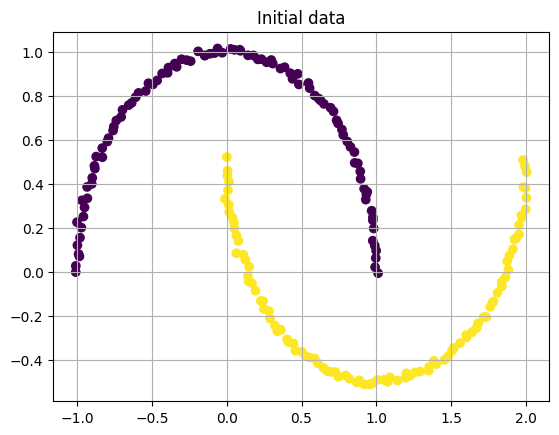

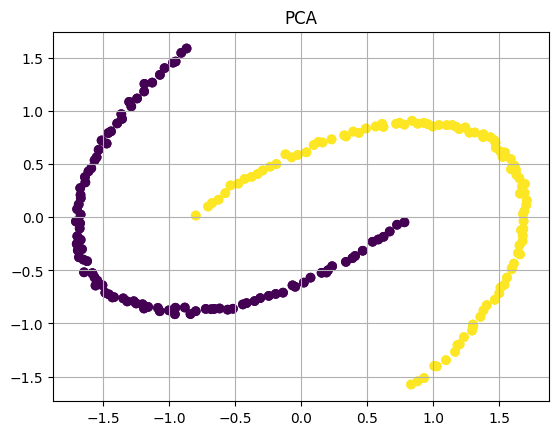

In [60]:
X, y = make_moons(n_samples=200, noise=0.01, random_state=42)
Xstd = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Initial data')
plt.grid(True)
plt.show()

# PCA with sklearn.decomposition
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xstd)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title('PCA')
plt.grid(True)
plt.show()

Проверим линейную разделимость с помощью SVM. Если на тесте получим accuracy близкое к 1, можно сказать что данные линейно разделимы.
Изначально, что изначальные данные линейно не разделимы.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

accuracy

0.9

Теперь создадим функции для вычисления матриц различных ядер и проведем спектральное разложение. Будем использовать три типа ядер: полиномиальное, RBF и сигмоидальное.

In [55]:
# Calculation of kernels
def rbf_kernel(x1, x2, gamma):
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)


def polynomial_kernel(x1, x2, degree, coef0):
    return (np.dot(x1, x2) + coef0) ** degree


def sigmoid_kernel(x1, x2, gamma, coef0):
    return np.tanh(gamma * np.dot(x1, x2) + coef0)


# Наш Kernel PCA function
def kernel_pca(X, n_components, gamma=None, degree=None, coef0=0, kernel=None):
    n_samples, n_features = X.shape
    # вычисление kernel matrix
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            if kernel == 'rbf':
                K[i, j] = rbf_kernel(X[i], X[j], gamma)
            elif kernel == 'poly':
                K[i, j] = polynomial_kernel(X[i], X[j], degree, coef0)
            elif kernel == 'sigmoid':
                K[i, j] = sigmoid_kernel(X[i], X[j], gamma, coef0)
            else:
                raise ValueError('kernel can be: rbf, poly or sigmoid')
    # Centering kernel matrix
    one_n = np.ones((n_samples, n_samples)) / n_samples
    K_centered = K - np.dot(one_n, K) - np.dot(K, one_n) \
    + np.dot(np.dot(one_n, K), one_n)

    # Вычисление собственных значений и собственных векторов
    eig_vals, eig_vecs = np.linalg.eigh(K_centered)

    # Сортировка собственных значений и собственных векторов
    idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]

    # выбор n components
    alphas = np.column_stack([eig_vecs[:, i] for i in range(n_components)])

    return alphas


def display(x1, x2, c, kernel=None, param=None):
    a = ['poly', 'sigmoid']
    titles = {
        'rbf1': 'sklearn KernelPCA - rbf',
        'rbf2': 'Our KernelPCA - rbf',
        'poly1': 'sklearn KernelPCA - poly',
        'poly2': 'Our KernelPCA - poly',
        'sigmoid1': 'sklearn KernelPCA - sigmoid',
        'sigmoid2': 'Our KernelPCA - sigmoid',
    }
    if kernel == 'rbf':
        if param % 2 != 0:
            title_text = titles['rbf1']
        else:
            title_text = titles['rbf2']
    elif kernel == 'poly':
        if param % 2 != 0:
            title_text = titles['poly1']
        else:
            title_text = titles['poly2']
    elif kernel == 'sigmoid':
        if param % 2 != 0:
            title_text = titles['sigmoid1']
        else:
            title_text = titles['sigmoid2']
    else:
        raise ValueError('kernel can be: rbf, poly or sigmoid')

    plt.title(title_text)
    plt.scatter(x1, x2, c=c)
    plt.grid(True)
    if kernel in a and param % 2 == 0:
        plt.gca().invert_xaxis()
    plt.show()

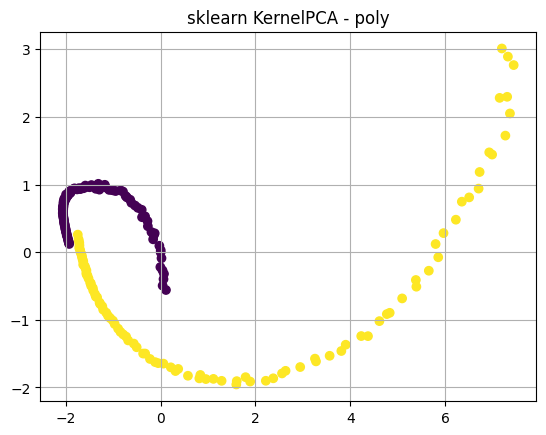

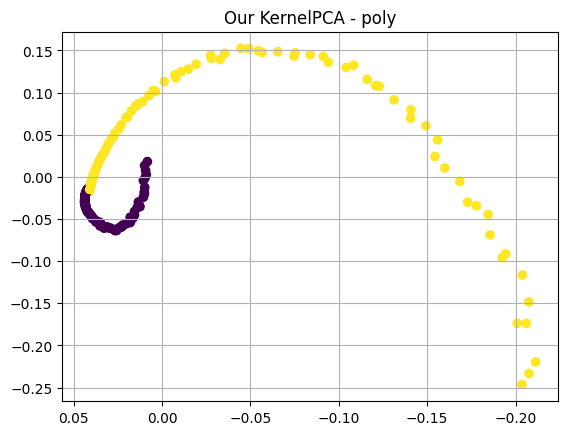

Точность классификации на полиномиальном ядре: 0.75


In [56]:
# Установим число компонентов
n_components = 2

# Применение KernelPCA от sklearn с полиномиальным ядром
kpca = KernelPCA(kernel='poly', degree=4, coef0=1, n_components=n_components)
X_kpca = kpca.fit_transform(X)
display(X_kpca[:, 0], X_kpca[:, 1], c=y, kernel='poly', param=1)

# Применение собственной функции KernelPCA с полиномиальным ядром
own_poly = kernel_pca(X, n_components=n_components, coef0=1, kernel='poly', degree=4)
display(own_poly[:, 0], own_poly[:, 1], c=y, kernel='poly', param=2)

# Проверка линейной разделимости данных с использованием SVM
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(own_poly, y, test_size=0.2, random_state=42)

# Обучение модели SVM на преобразованных данных
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

# Вывод точности
print("Точность классификации на полиномиальном ядре:", accuracy)

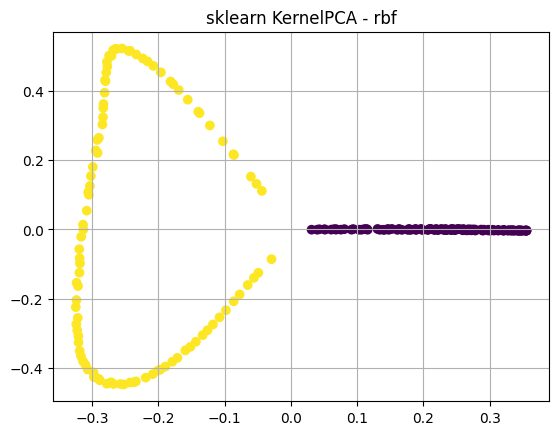

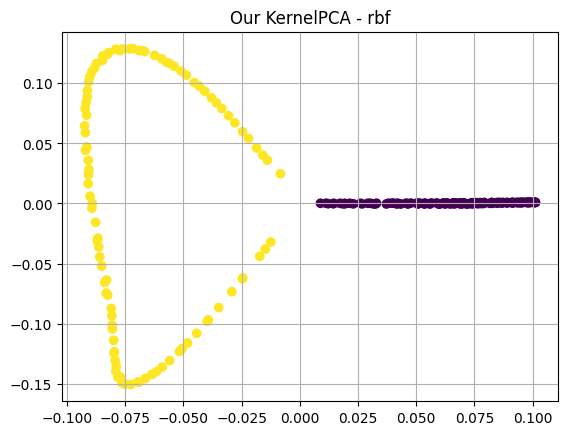

Точность классификации на RBF ядре: 1.0


In [57]:
# Применение KernelPCA от sklearn с RBF ядром
gamma_rbf = 20
kpca_rbf = KernelPCA(kernel='rbf', gamma=gamma_rbf, n_components=n_components)
X_kpca_rbf = kpca_rbf.fit_transform(X)
display(X_kpca_rbf[:, 0], X_kpca_rbf[:, 1], c=y, kernel='rbf', param=1)

# Применение собственной функции KernelPCA с RBF ядром
own_rbf = kernel_pca(X, n_components=n_components, gamma=gamma_rbf, kernel='rbf')
display(own_rbf[:, 0], own_rbf[:, 1], c=y, kernel='rbf', param=2)

# Проверка линейной разделимости данных с использованием SVM
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(own_rbf, y, test_size=0.2, random_state=42)

# Обучение модели SVM на преобразованных данных
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
accuracy_rbf = clf.score(X_test, y_test)

# Вывод точности
print("Точность классификации на RBF ядре:", accuracy_rbf)

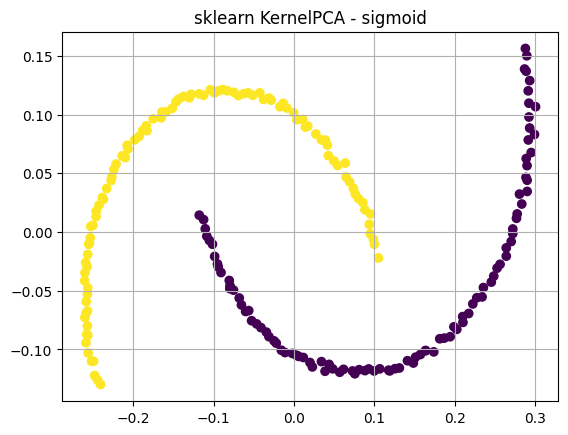

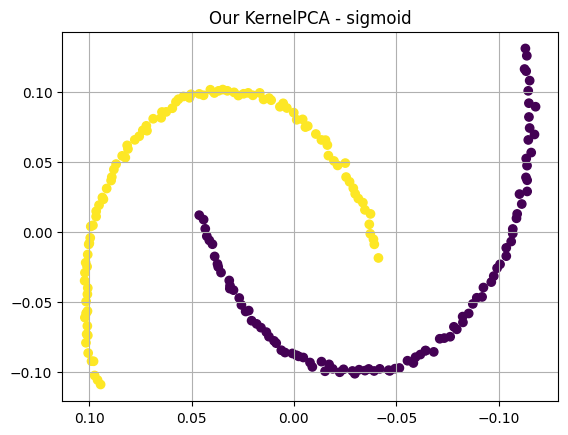

Точность классификации на сигмоидальном ядре: 0.925


In [58]:
# Применение KernelPCA от sklearn с сигмоидальным ядром
gamma_sigmoid = 0.1
coef0_sigmoid = 1
kpca_sigmoid = KernelPCA(kernel='sigmoid', gamma=gamma_sigmoid, coef0=coef0_sigmoid, n_components=n_components)
X_kpca_sigmoid = kpca_sigmoid.fit_transform(X)
display(X_kpca_sigmoid[:, 0], X_kpca_sigmoid[:, 1], c=y, kernel='sigmoid', param=1)

# Применение собственной функции KernelPCA с сигмоидальным ядром
own_sigmoid = kernel_pca(X, n_components=n_components, gamma=gamma_sigmoid, coef0=coef0_sigmoid, kernel='sigmoid')
display(own_sigmoid[:, 0], own_sigmoid[:, 1], c=y, kernel='sigmoid', param=2)

# Проверка линейной разделимости данных с использованием SVM
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(own_sigmoid, y, test_size=0.2, random_state=42)

# Обучение модели SVM на преобразованных данных
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
accuracy_sigmoid = clf.score(X_test, y_test)

# Вывод точности
print("Точность классификации на сигмоидальном ядре:", accuracy_sigmoid)

### Сравнительный анализ применения PCA и Kernel PCA

PCA является линейным методом, который применяется для поиска линейных комбинации исходных признаков, которые максимально описывают дисперсию данных. Это означает, что PCA подходит для данных, в которых главные компоненты имеют линейные зависимости.  

Kernel PCA является нелинейным методом, который способен выявлять нелинейные зависимости между данными, благодаря применению ядерных функций.  
* RBF ядро показало наилучшие результаты, достигнув 100% точности на данных с разделением.
* Полиномиальное и сигмоидальное ядра также улучшили линейную разделимость данных. Полиномиальное ядро дало точность 75%, тогда как сигмоидальное достигло 90%. Это также показывает, что ядра по-разному подходят для выявления сложных зависимостей, и точность может варьироваться в зависимости от типа ядра.

Таким образом, Kernel PCA является полезным методом для улучшения классификации на линейно неразделимых данных, и выбор ядра должен основываться на природе данных, чтобы достичь максимального улучшения.